In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt


from pymongo import MongoClient
import pprint

import copy
import pandas as pd

# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

import re
from time import sleep

#list of aircraft
#aicraft_list = ['Pilatus PC-12', 'Cessna Caravan', 'Beechcraft Super King Air 200', 'Cessna Citation Excel/XLS']

aircraft = input('Enter Aircraft Name:')

#function to retrieve webpage
def request(web):

  r = requests.get(web)
  client = MongoClient('localhost', 27017)
  db = client.metroid
  pages = db.pages
  pages.insert_one({'html': r.content})
  soup = (BeautifulSoup(r.content, "html.parser"))
  return soup

#function to find the code for each aircraft - this will help when looking through webpage
#can be removed if code is given instead of name
def find_aircraft(name):
  soup = request('https://flightaware.com/live/aircrafttype/')
  #table has 2 classes
  table = soup.find_all(class_ = 'smallrow1')
  table2 = soup.find_all(class_ = 'smallrow2')

  name = name.replace(' ', '').lower()

  #iterate though both tables to find code - when found stops function
  for row in table:
    columns = row.find_all('td')
    aircraft = columns[2].text.strip()

    aircraft = aircraft.replace(' ', '').lower()

    if aircraft == name:
      code = (columns[1].text.strip())
      break
    else:
      continue

  for row in table2:
    columns = row.find_all('td')
    aircraft = columns[2].text.strip()

    aircraft = aircraft.replace(' ', '').lower()
    if aircraft == name:
      code = (columns[1].text.strip())
      break
    else:
      continue

  return code


def aircraftinfo(name):

  code = find_aircraft(name)

  new_table = pd.DataFrame(columns = ['Ident', 'Type', 'Origin', 'Destination', 'Depature', 'Arrival Time', 'Time in Route'])

  #to look at more than one page shows, have to iterate - max of 500 flights will be found

  for num in range(0,500, 20):
    web = f'https://flightaware.com/live/aircrafttype/{code};offset={num}'
    soup = request(web)

    table = soup.find('table', class_ = 'prettyTable fullWidth')
    rows = table.find_all('tr')

    for x in rows:
      col = x.find_all('td')
      row = [i.text for i in col]
      if len(row) == 7:
        n_row = pd.DataFrame([row], columns = ['Ident', 'Type', 'Origin','Destination', 'Depature', 'Arrival Time', 'Time in Route'])
        new_table = new_table.append(n_row )
      else:
        continue

  new_table['Time in Route'] = pd.to_datetime(new_table['Time in Route']).dt.strftime('%H:%M:%S')
  avg = pd.to_timedelta(new_table['Time in Route']).mean()





  return(new_table)


table = (aircraftinfo(aircraft))


Enter Aircraft Name:Cessna Caravan


In [6]:
table.head(10)

,Ident,Type,Origin,Destination,Depature,Arrival Time,Time in Route
0,IRO7440,C208,Houghton County Memorial (KCMX),Milwaukee Mitchell Intl Airport (KMKE),Tue 06:02PM EST,Tue 06:43PM CST,01:30:00
0,N900WA,C208,Fairbanks Intl (FAI / PAFA),,Tue 02:01PM AKST,,NaN
0,IRO7580,C208,Houghton County Memorial (KCMX),,Tue 06:00PM EST,,NaN
0,N829JP,C208,Fort Worth Meacham Intl (KFTW),William P Hobby (KHOU),Tue 05:00PM CST,Tue 06:38PM CST,01:34:00
0,WIG478,C208,Manchester (KMHT),Newark Liberty Intl (KEWR),Tue 05:59PM EST,Tue 07:25PM EST,01:25:00
0,N94AW,C208,Fairbanks Intl (FAI / PAFA),,Tue 01:59PM AKST,,NaN
0,N750KP,C208,Juneau Intl (JNU / PAJN),,Tue 01:59PM AKST,,NaN
0,CPT7714,C208,Lanai (LNY / PHNY),Daniel K Inouye Intl (PHNL),Tue 12:57PM HST,Tue 01:28PM HST,00:31:00
0,N292SS,C208,Guam Intl (PGUM),Benjamin Taisacan Manglona Intl (PGRO),Wed 08:56AM ChST,Wed 09:17AM ChST,00:20:00
0,VH-PQX,C208,Mount Isa (ISA / YBMA),Townsville Int'l / RAAF (TSV / YBTL),Wed 08:55AM AEST,Wed 11:43AM AEST,02:47:00


In [7]:
import matplotlib.pyplot as plt
import seaborn as sea
sea.set()
sea.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [9]:
Origin = table['Origin'].value_counts()

In [10]:
origin = Origin.to_dict()

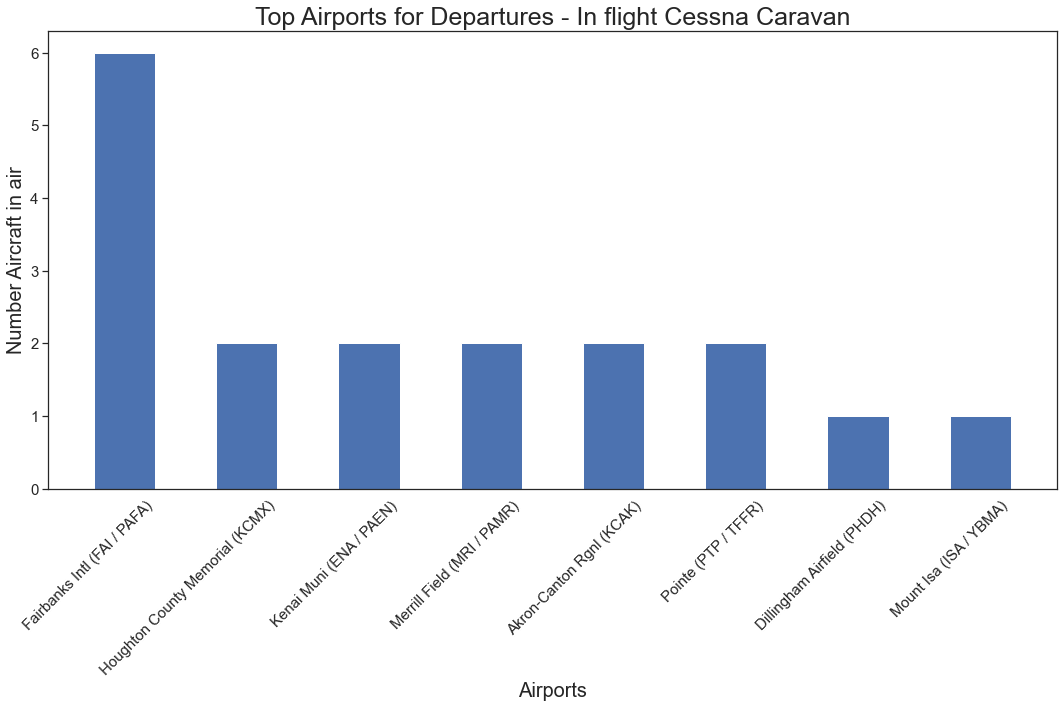

In [73]:
x = list(origin.keys())[0:8]
y = list(origin.values())[0:8]

fig, ax = plt.subplots(figsize = (15,10))

plt.bar(x,y,-.5, align='edge')
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 15)
plt.yticks(fontsize = 15)
plt.tick_params(axis = "x", bottom = False, top = False)
plt.xlabel('Airports', fontsize='20')
plt.ylabel('Number Aircraft in air',  fontsize='20')
plt.title(f'Top Airports for Departures - In flight {aircraft}', fontsize = 25)
plt.tight_layout()
plt.savefig('/Users/samanthajamwal/Documents/untitled folder/Portfolio/Top_Dept.png')

In [32]:
table_new = table.dropna()
Dest = table_new['Destination'].value_counts()
dest = Dest.to_dict()

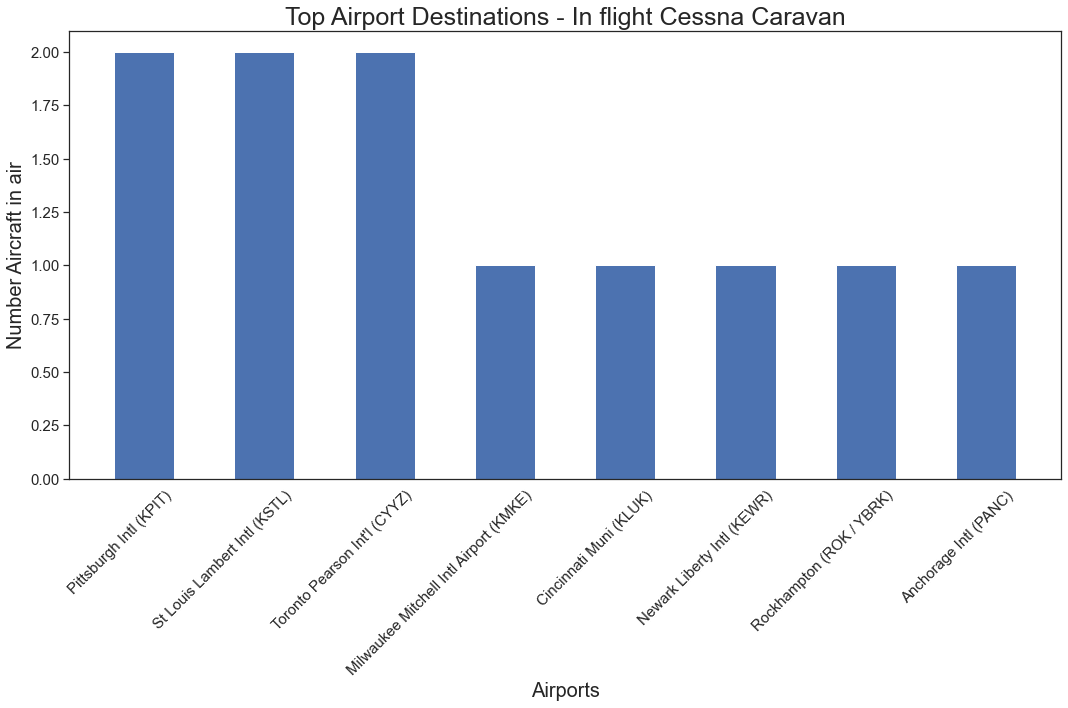

In [74]:
x = list(dest.keys())[0:8]
y = list(dest.values())[0:8]

fig, ax = plt.subplots(figsize = (15,10))

plt.bar(x,y,-.5, align='edge')
plt.xticks(rotation=45, horizontalalignment='right', fontsize = 15)
plt.yticks(fontsize = 15)
plt.tick_params(axis = "x", bottom = False, top = False)
plt.xlabel('Airports', fontsize='20')
plt.ylabel('Number Aircraft in air',  fontsize='20')
plt.title(f'Top Airport Destinations - In flight {aircraft}', fontsize = 25)
plt.tight_layout()
plt.savefig('/Users/samanthajamwal/Documents/untitled folder/Portfolio/Top_Dest.png')